<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> Seminar #3: ARIMAX, Compositions

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

**Key words:** 
    - stationary TS, ARMA, ARIMA, ARIMAX, equvalence ARIMA and ES models

<h3> Plan </h3>
  * **HW1 solution** (20 minutes)
     
  * ** ARIMAX for energy consumption ** (30 minutes)
      - Forecasting stationary TS with ARMA
      - Forecasting with ARMAX,
      - Forecasting with SARIMAX
     
  * **Compositions: ** (30 minutes)</span> 
     - Adaptive Selection  
     - Adaptive Composition 
     - <span style="color:orange; font-size: 10pt"> Aggregation Algorithm </span> (self-study)

In [63]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
import plotly.plotly as py
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE

%matplotlib inline

<h1 align="center"> HW1 solution </h1>

<h1 align="center"> Stationarity of TS </h1>
** Questions: **
   * What is stationaty TS?
   * How to make TS stationary?
      - Hint: see <a href="https://github.com/ml-mipt/ml-mipt-part2/blob/master/2017/lectures/tsa_arima.pdf">lecture 2</a>
      
# Examples of TS 

## Energy Consumption

In [14]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts.head()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2010-01-01,Center,FZSZOE27,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,Center,FZSZOE27,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Center,FZSZOE27,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,Center,FZSZOE27,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,Center,FZSZOE27,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Filter only Hub=Center and ZSP=FZSZOE27
energy_ts= energy_ts[(energy_ts['ZSP']=='FZSZOE27') & (energy_ts['Hub']=='Center')]
energy_ts.tail()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2015-05-23,Center,FZSZOE27,NaN,11.7,11.9,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-24,Center,FZSZOE27,NaN,12.4,12.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,Center,FZSZOE27,NaN,16.2,15.4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-26,Center,FZSZOE27,NaN,18.7,17.3,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-27,Center,FZSZOE27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


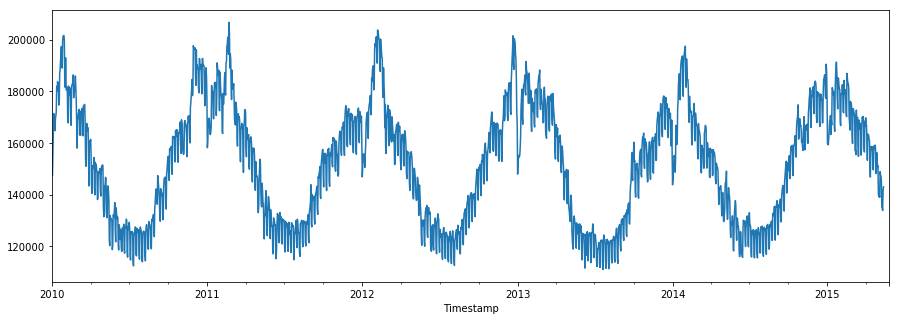

In [46]:
# See Year-Seasonality
energy_ts['EnergyConsump'].plot(figsize=(15,5))

# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_YearSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

**Questions** 
    - Which components of TS do you see?
    - Are there any dependences on other variables?
    - Is that TS stationary? Why?

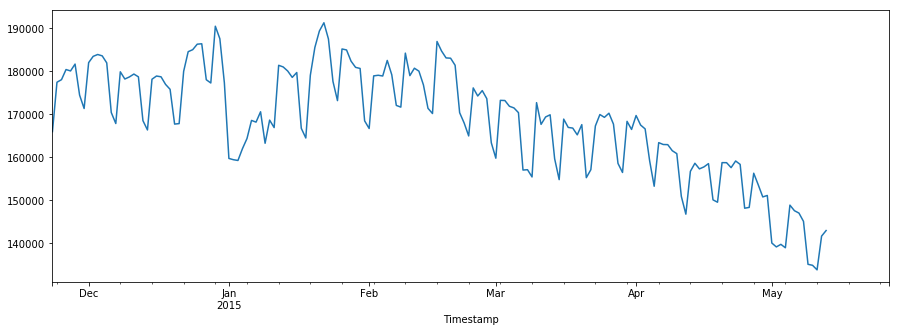

In [50]:
# See Week easonality
energy_ts['EnergyConsump'].tail(186).plot(figsize=(15,5))

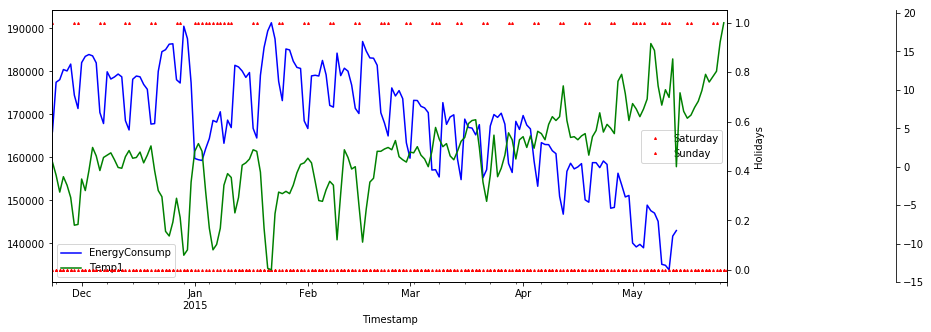

In [51]:
# See dependence on other varibales
fig, ax = plt.subplots(figsize=(15,5))
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

# Making TS Stationary by Box-Cox transformation

## $$ y'_t=\begin{cases}
		\ln y_t, & \lambda=0, \\
		\left(y_t^\lambda-1\right)/\lambda, & \lambda\neq 0.
		\end{cases}
		$$	


<img src='./pic/box-cox_fig1.jpg', width="300px">

After the forecast for the transformed time series is built it should be transformed into forecast of the initial time series:
## 		$$
		\hat{y}_t=\begin{cases}
		\exp\left(\hat{y}'_t\right), & \lambda=0, \\
		\left(\lambda\hat{y}'_t+1\right)^{1/\lambda}, & \lambda\neq 0.
		\end{cases}
		$$			

It helps to make TS plain in terms of variance of its values:
<img src='./pic/logtrans.png'>

## Wage TS

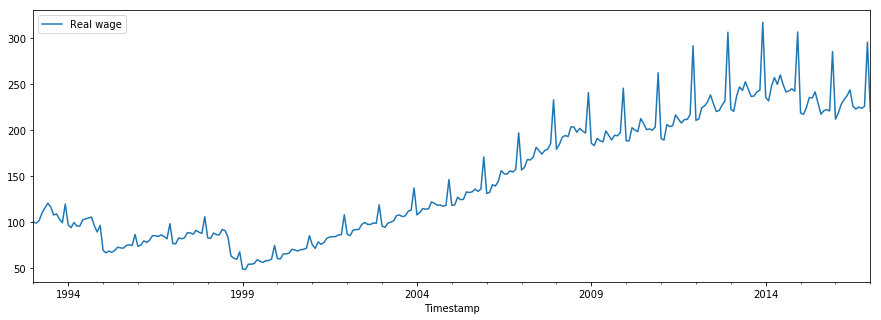

In [53]:
# plot time series
ts_wage.plot(figsize=(15,5))

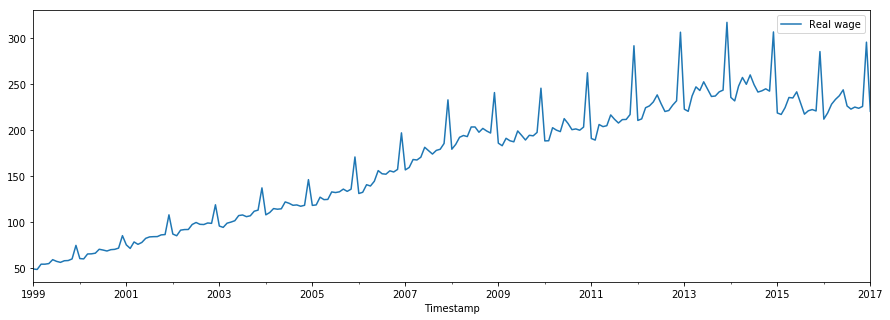

In [68]:
# cut first steps
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(15,5))

 * Make it Stationary in term of variance of its values

In [60]:
from copy import deepcopy
ts_wage_boxcox = deepcopy(ts_wage)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage)[1][0])

optimal lambda: 0.922708974798


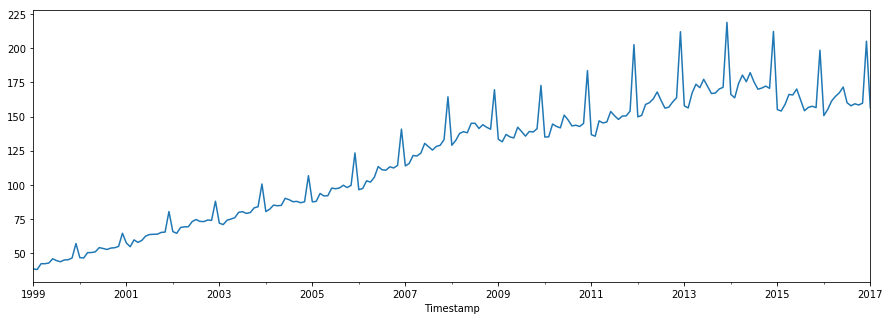

In [69]:
ts_wage_boxcox['wage_boxcox'] = stats.boxcox(ts_wage)[0]
ts_wage_boxcox['wage_boxcox'].plot(figsize=(15,5))

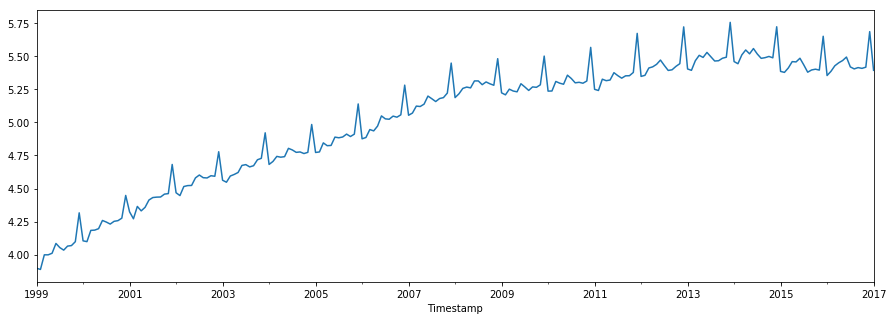

In [70]:
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
ts_wage_boxcox['wage_boxcox'].plot(figsize=(15,5))
# a= stats.boxcox(np.array(ts_wage['Real wage']), lmbda=0.1, alpha=0.05)[0]

** Questions: **
   * Which $\lambda$ is better for this TS (0 or 0.92)?
   * Is transformed TS stationary?

# Making TS Stationary by Differencing
## $$y_1,\dots,y_T \;\longrightarrow\;y'_2,\dots,y'_{T}, $$
## $$y'_t = y_t - y_{t-1}.$$
		
Seasonal differencing:
		
## $$y_1,\dots,y_T \;\longrightarrow \;y'_{s+1},\dots,y'_{T}, $$
## 		$$y'_t = y_t - y_{t-s}.$$	    
    

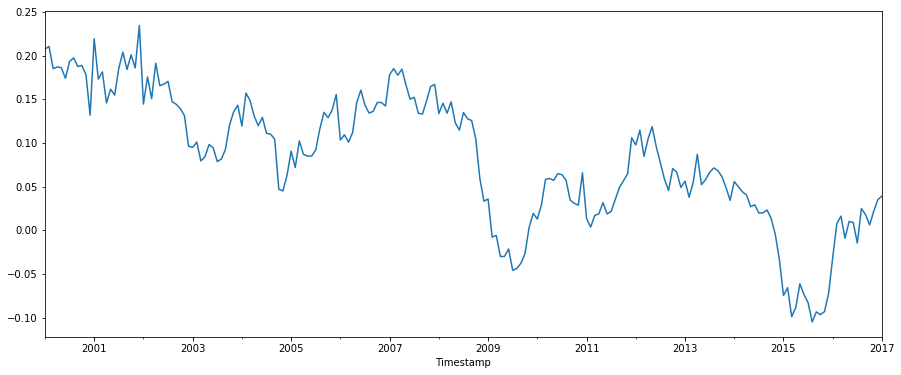

In [71]:
# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts_wage_boxcox.plot(figsize=(15,6))

** Questions:**
   * Is that TS stationary?

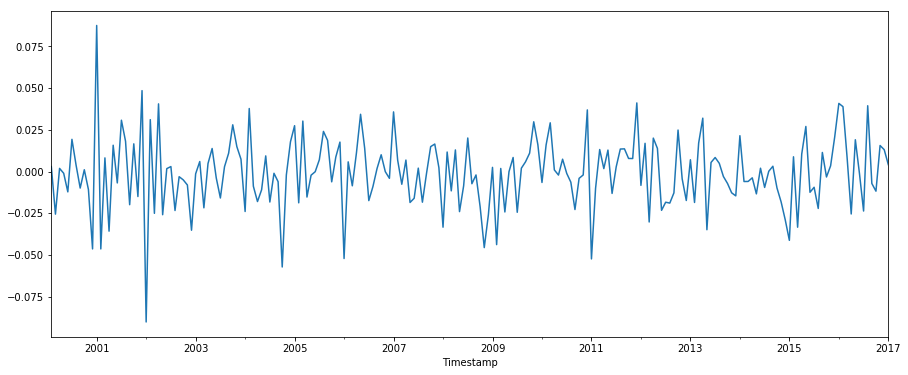

In [72]:
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot(figsize=(15,6))

** Questions:**
   * Is that TS stationary?
   * How to check it? (Which statistical tests do you know?)

In [73]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(np.array(diff_sdiff_ts_wage_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.062453, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [78]:
# Augmented Dickey-Fuller unit root test
df_stat = stattools.adfuller(np.array(diff_sdiff_ts_wage_boxcox))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -5.227607, 
pvalue: 0.00 
maximal Lag: 11 
critical values: {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.5748586990017359}


<h1 align="center"> ARIMA family models </h1>

# ARIMA model and Stationarity
$$y_t = \underbrace{c+\sum_{i=1}^{p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

or in canonical form (using back-operator $B$):

$$\phi\left(B\right)(y_t-\mu) = \theta\left(B\right)\varepsilon_t.$$

$\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

** Question: **
   * What is $\phi\left(B\right)$ and $\theta\left(B\right)$?
    
    

** Questions: **
  * Write down equation in canonical form for next TS:
       - 1) $y_t ={y_{t-1}} + 1 +\varepsilon_t$
       - 2) $y_t =y_{t - p} +\varepsilon_t$, where $p>1$ - period of seasonality
  
    <Answer>
   
* Show that $\phi(B)$ in equations above has unit roots.
   
   <Answer>
   
* Explain why linear operator $1-B$ is not invertable 
       Hint:
       - 1) show that back operator $B$ is a linear operator with norm 1;
       - 2) use the fact that if $||A||=1\Rightarrow $(1-A)$ is not invertable
* Why ARMA model works only with stationary TS? 

# ARMA for forecasing Retail Time Series

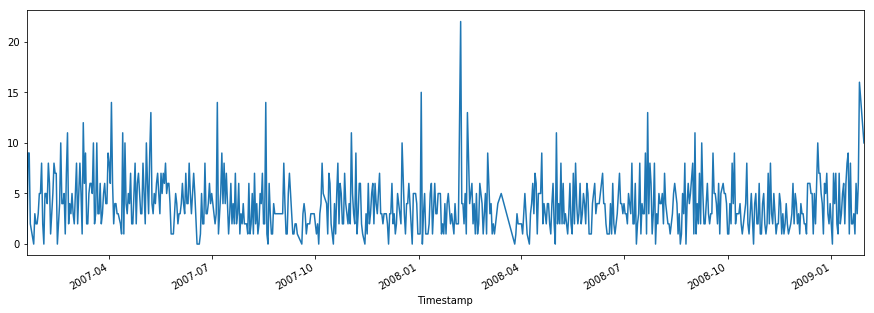

In [82]:
# удаляем пропуски: иначе нельзя
dta = ts[ts.columns[0]].dropna()
dta.plot(figsize=(15,5))

In [83]:
# Stationary test
kpss_stat= stattools.kpss(np.array(dta))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.509193, 
pvalue: 0.04 
maximal Lag: 20 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


** Question **
   * How to choose parameters $p$ and $q$ for ARMA model?

## Autocorrelation analysis

** Questions **
    * What is autocorrelation function (ACF)?
    * What does coefficient of correlation show?
    * What is partial autocorrelation function (PACF)?  What does coefficient of partial correlation show?
    * How do ACF and PACF help to choose p and q of ARMA model?
    
    
Autocorrelation coeficient:
### $$ r_\tau = r_{y_t y_{t+\tau}} = \frac{\sum\limits_{t=1}^{T-\tau} \left(y_t - \bar{y}\right)\left(y_{t+\tau} - \bar{y}\right) }{ \sum\limits_{t=1}^T \left(y_t - \bar{y}\right)^2 },\;\; \bar{y} = \frac1{T} \sum_{t=1}^T y_t.$$
		
$r_\tau \in\left[-1,1\right], \;\; \tau$ - autocorrelation lag.

** Coefficient of partial correlation:** between $y$, $x_1$ без учёта зависимости от $x_2$**

<img src='./pic/PACF.png'>

<span style="color:red">Коэффициент частной корреляции</span> отражает похожесть между отсчётами $y_t$ и $y_{t-k}$, <span style="color:red">КОТОРАЯ НЕ ПРОЯВЛЯЕТСЯ</span>
   - <span style="color:red">между отсчётами $y_t$ и $y_{t-1}$</span>
   - <span style="color:red">между отсчётами $y_t$ и $y_{t-2}$</span>
   
   ...
   
   - <span style="color:red">между отсчётами $y_t$ и $y_{t-(k-1)}$</span>    


* Autocorrelation analysis

https://onlinecourses.science.psu.edu/stat510/node/62

http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.acf.html

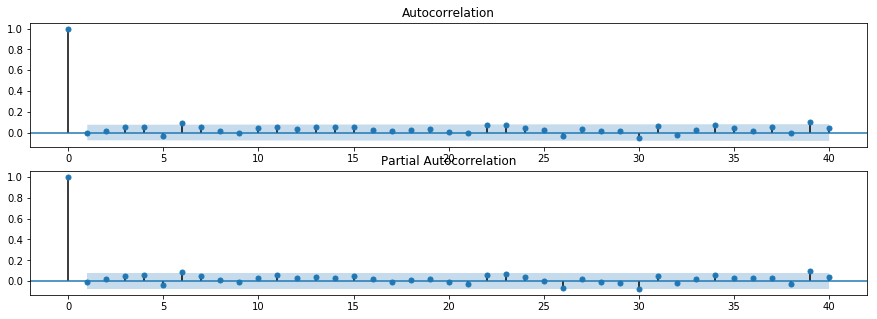

In [81]:
# Use Item 165
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

* try just simple ARMA models

In [41]:
arma_mod10 = sm.tsa.ARMA(dta, (1,0)).fit()
print(arma_mod10.params)
print(arma_mod10.aic, arma_mod10.bic, arma_mod10.hqic)

const               3.910796
ar.L1.Item:  165   -0.007255
dtype: float64
(3301.602584786089, 3315.1864585389567, 3306.8591498132796)


In [42]:
arma_mod01 = sm.tsa.ARMA(dta, (0,1)).fit()
print(arma_mod01.params)
print(arma_mod01.aic, arma_mod01.bic, arma_mod01.hqic)

const               3.910795
ma.L1.Item:  165   -0.006996
dtype: float64
(3301.603847883614, 3315.1877216364815, 3306.8604129108044)


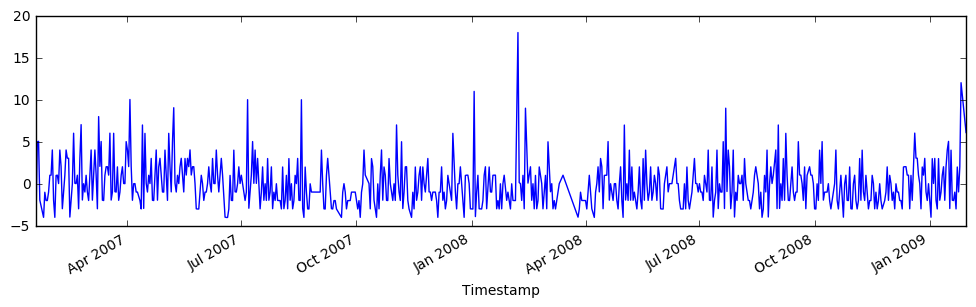

In [172]:
# plot residuals
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = arma_mod01.resid.plot(ax=ax);

### Unbiasedness test

In [98]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arma_mod01.resid.values)

1.9894592955896726

In [46]:
stat = stats.wilcoxon(arma_mod01.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 112078.000000
pvalue: 0.33


In [48]:
# Normal test
resid = arma_mod01.resid
stats.normaltest(resid)

NormaltestResult(statistic=212.08351416703624, pvalue=8.8440267461256245e-47)

* Hypothesis of normality can be rejected

### Analyse ACF, PACF for residals

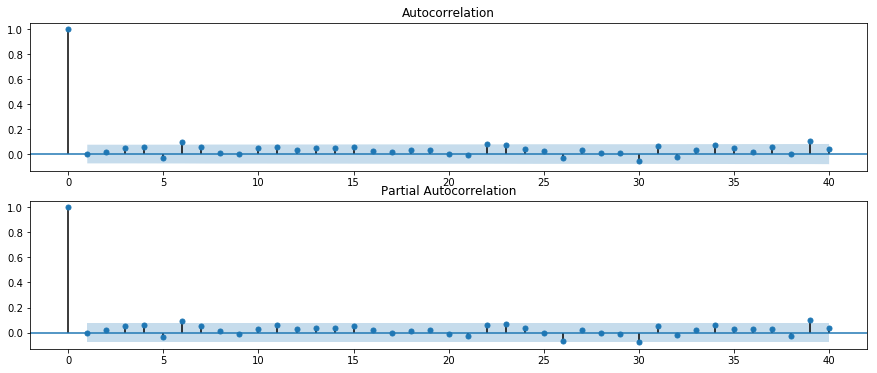

In [49]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [102]:
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.000119   0.000010  0.997512
2.0   0.018180   0.227398  0.892527
3.0   0.051004   2.019795  0.568308
4.0   0.057548   4.305060  0.366292
5.0  -0.031707   4.999802  0.415904
6.0   0.095845  11.357386  0.077939
7.0   0.056103  13.538901  0.060017
8.0   0.011613  13.632504  0.091861
9.0  -0.002443  13.636652  0.135850
10.0  0.044627  15.023150  0.131220
11.0  0.057814  17.353556  0.097844
12.0  0.035986  18.257807  0.108084
13.0  0.051329  20.100197  0.092740
14.0  0.049316  21.803492  0.082743
15.0  0.056200  24.018733  0.064776
16.0  0.025206  24.465007  0.079829
17.0  0.014184  24.606530  0.103870
18.0  0.028825  25.191932  0.119720
19.0  0.032562  25.940081  0.131867
20.0  0.003018  25.946519  0.167585
21.0 -0.005967  25.971719  0.207529
22.0  0.077311  30.208225  0.113491
23.0  0.076280  34.338749  0.060416
24.0  0.043199  35.665492  0.059124
25.0  0.021447  35.992992  0.071706
26.0 -0.035554  36.894418  0

### Forecast of Validation Period

In [135]:
frc_arma = arma_mod01.predict('2008-12-30', '2008-12-31', dynamic=False)
print(frc_arma)

Timestamp
2008-12-30    3.917016
2008-12-31    3.924208
dtype: float64


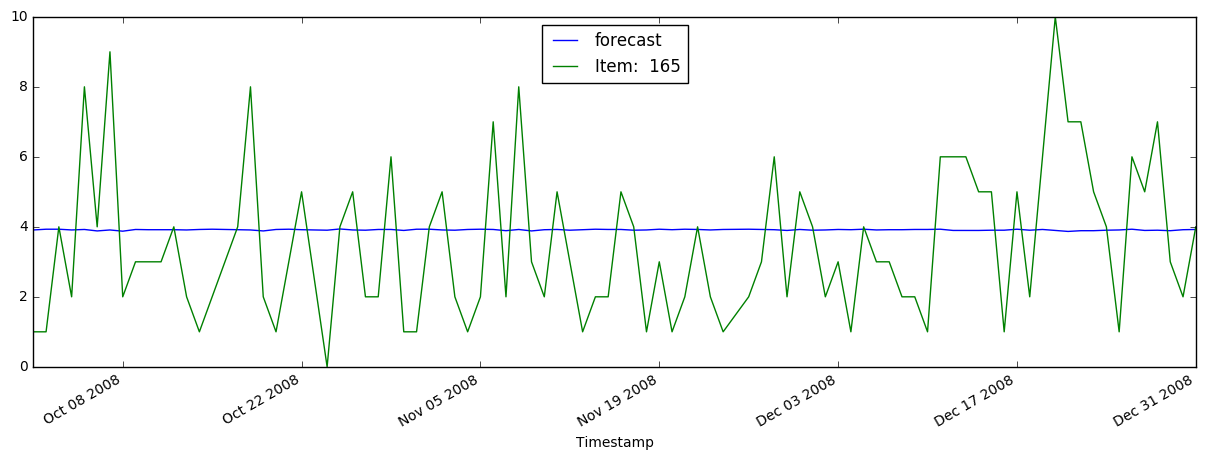

In [173]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arma_mod01.plot_predict(start='2008-10-01', end='2008-12-31', ax=ax)

### Forecast of Future Period

In [130]:
frc_arma = arma_mod01.forecast(steps=185)
print(frc_arma[1])

[ 2.69158051  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2

# ARIMA

## ARIMAX

In [51]:
energy_ts.columns

Index([u'Hub', u'ZSP', u'EnergyConsump', u'Temp1', u'Temp2', u'Temp3',
       u'Temp4', u'Temp5', u'Temp6', u'Temp7', u'Saturday', u'Sunday',
       u'Temp1_South_Less', u'Temp2_South_Less', u'Temp3_South_Less',
       u'Temp4_South_Less', u'Temp1_South_Gr', u'Temp2_South_Gr',
       u'Temp3_South_Gr', u'Temp4_South_Gr'],
      dtype='object')

In [52]:
dta = energy_ts[['EnergyConsump','Temp1', 'Temp2', 'Saturday','Sunday']].dropna()
exogs = dta[['Temp1', 'Temp2', 'Saturday','Sunday']][dta.index<'2015-05-01']
extra_exogs = dta[['Temp1', 'Temp2', 'Saturday','Sunday']]
dta = dta[['EnergyConsump']][dta.index<'2015-05-01']
extra_exogs.tail(13)

,Temp1,Temp2,Saturday,Sunday
Timestamp,,,,
2015-05-01,8.2,5.1,0.0,1.0
2015-05-02,7.5,4.9,1.0,0.0
2015-05-03,6.5,2.7,0.0,1.0
2015-05-04,7.5,3.1,0.0,1.0
2015-05-05,8.8,5.4,0.0,0.0
2015-05-06,16.0,10.6,0.0,0.0
2015-05-07,15.1,11.2,0.0,0.0
2015-05-08,10.5,9.6,0.0,0.0
2015-05-09,8.0,7.9,1.0,0.0


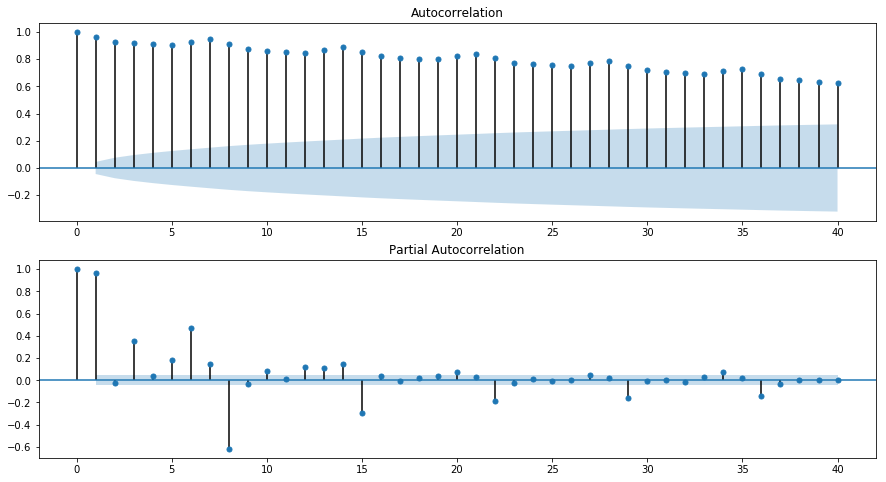

In [54]:
# Use energy data
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

** Question **
 - Can we use thiss ACF, PACF for choosing p,q?

In [55]:
# Only regressors
arima_mod000 = sm.tsa.ARIMA(dta, (0,0,0), exog=exogs).fit()
print(arima_mod000.params)
print(arima_mod000.aic, arima_mod000.bic, arima_mod000.hqic)

const       165786.199872
Temp1        -1472.723514
Temp2         -488.466321
Saturday     -9958.554880
Sunday      -12299.971714
dtype: float64
(40467.462212534301, 40500.903400110779, 40479.758125812972)


In [56]:
# only ARMA components
arima_mod710 = sm.tsa.ARIMA(dta, (7,1,0)).fit()
print(arima_mod710.params)
print(arima_mod710.aic, arima_mod710.bic, arima_mod710.hqic)

const                   -0.199795
ar.L1.D.EnergyConsump   -0.080273
ar.L2.D.EnergyConsump   -0.181358
ar.L3.D.EnergyConsump   -0.127230
ar.L4.D.EnergyConsump   -0.083809
ar.L5.D.EnergyConsump   -0.190023
ar.L6.D.EnergyConsump   -0.042998
ar.L7.D.EnergyConsump    0.617713
dtype: float64
(37575.45161494667, 37625.608770251143, 37593.894263184309)


C:\Users\rusrom\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



* ARMA + individual variables

In [109]:
arima_mod710_ex = sm.tsa.ARIMA(dta, (7,1,0), exog=exogs).fit()
print(arima_mod710_ex.params)
print(arima_mod710_ex.aic, arima_mod710_ex.bic, arima_mod710_ex.hqic)

const                     2342.900406
Temp1                       57.586023
Temp2                     -105.159365
Saturday                -11256.039610
Sunday                   -4540.695095
ar.L1.D.EnergyConsump       -0.017472
ar.L2.D.EnergyConsump       -0.032838
ar.L3.D.EnergyConsump       -0.109722
ar.L4.D.EnergyConsump       -0.082320
ar.L5.D.EnergyConsump       -0.050773
ar.L6.D.EnergyConsump       -0.022363
ar.L7.D.EnergyConsump        0.586471
dtype: float64
(37268.213791787486, 37340.663016116167, 37294.853172575182)


C:\Users\rusrom\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [113]:
arima_mod910_ex = sm.tsa.ARIMA(dta, (9,1,0), exog=exogs).fit()
print(arima_mod910_ex.params)
print(arima_mod910_ex.aic, arima_mod910_ex.bic, arima_mod910_ex.hqic)

const                     2519.366385
Temp1                      136.869813
Temp2                     -160.896848
Saturday                -10476.775169
Sunday                   -8954.911408
ar.L1.D.EnergyConsump        0.192624
ar.L2.D.EnergyConsump        0.009757
ar.L3.D.EnergyConsump       -0.085329
ar.L4.D.EnergyConsump       -0.062105
ar.L5.D.EnergyConsump       -0.138750
ar.L6.D.EnergyConsump        0.035232
ar.L7.D.EnergyConsump        0.555617
ar.L8.D.EnergyConsump       -0.113736
ar.L9.D.EnergyConsump       -0.170689
dtype: float64
(37198.56233547239, 37282.157594313176, 37229.300082535112)


C:\Users\rusrom\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [110]:
print(arima_mod710_ex.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.EnergyConsump   No. Observations:                 1945
Model:                 ARIMA(7, 1, 0)   Log Likelihood              -18621.107
Method:                       css-mle   S.D. of innovations           3477.347
Date:                Tue, 01 Nov 2016   AIC                          37268.214
Time:                        02:31:58   BIC                          37340.663
Sample:                    01-02-2010   HQIC                         37294.853
                         - 04-30-2015                                         
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                  2342.9004        nan        nan        nan           nan       nan
Temp1                    57.5860     28.842      1.997      0.046         1.058   114.114
Temp2   

C:\Users\rusrom\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning:

TimeSeries is deprecated. Please use Series



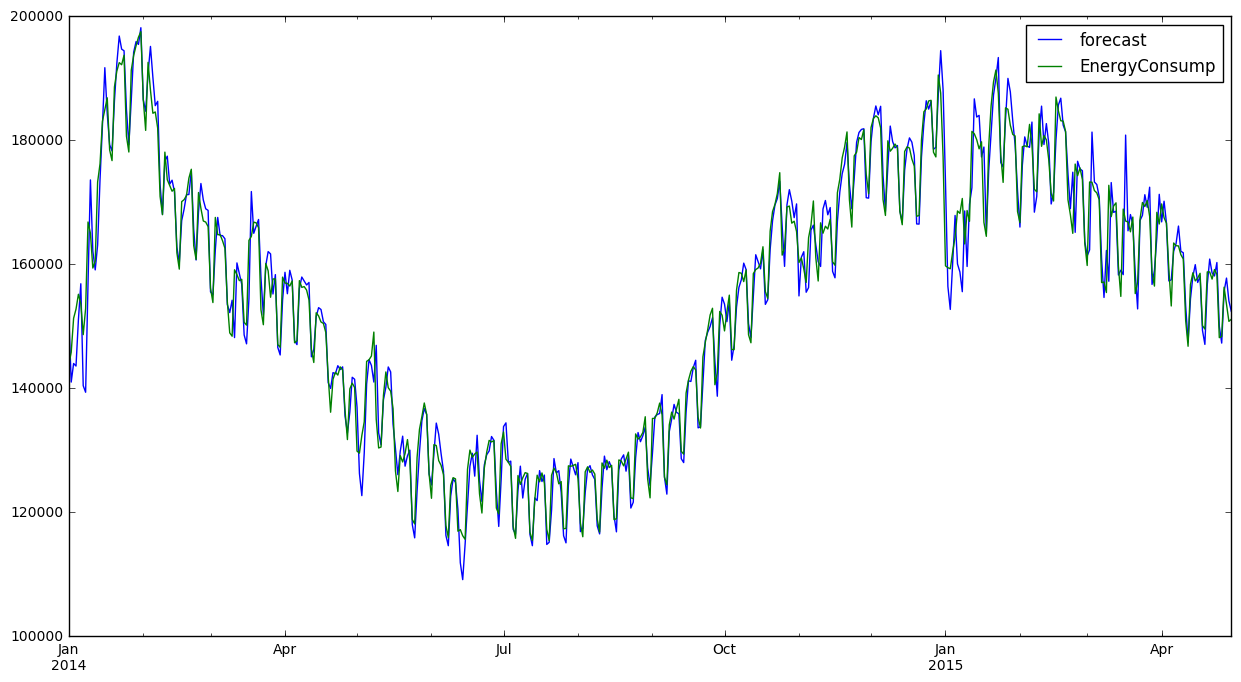

In [111]:
fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
fig = arima_mod710_ex.plot_predict(start='2014-01-01', end='2015-04-30', ax=ax)
# legend = ax.legend(loc='upper left')

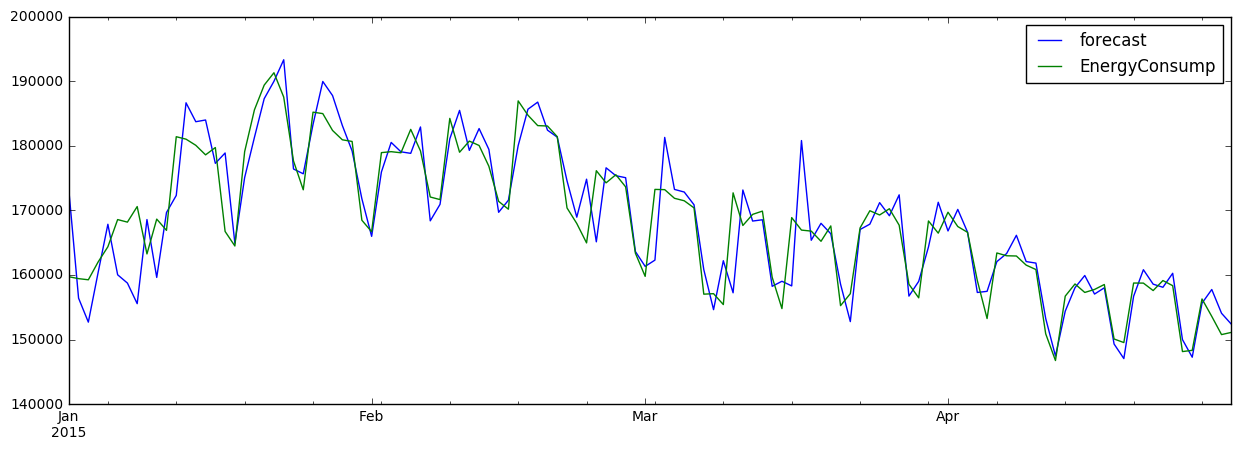

In [147]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod710_ex.plot_predict(start='2015-01-01', end='2015-04-30', ax=ax)
# legend = ax.legend(loc='upper left')

In [161]:
# fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
# fig = arima_mod710_ex.plot_forecast(185)
frc = arima_mod710_ex.forecast(steps = 13, exog = extra_exogs[extra_exogs.index>='2015-05-01'])

frc_arimax = extra_exogs[extra_exogs.index>='2015-05-01']
frc_arimax['FRC'] = frc[0]
frc[0]

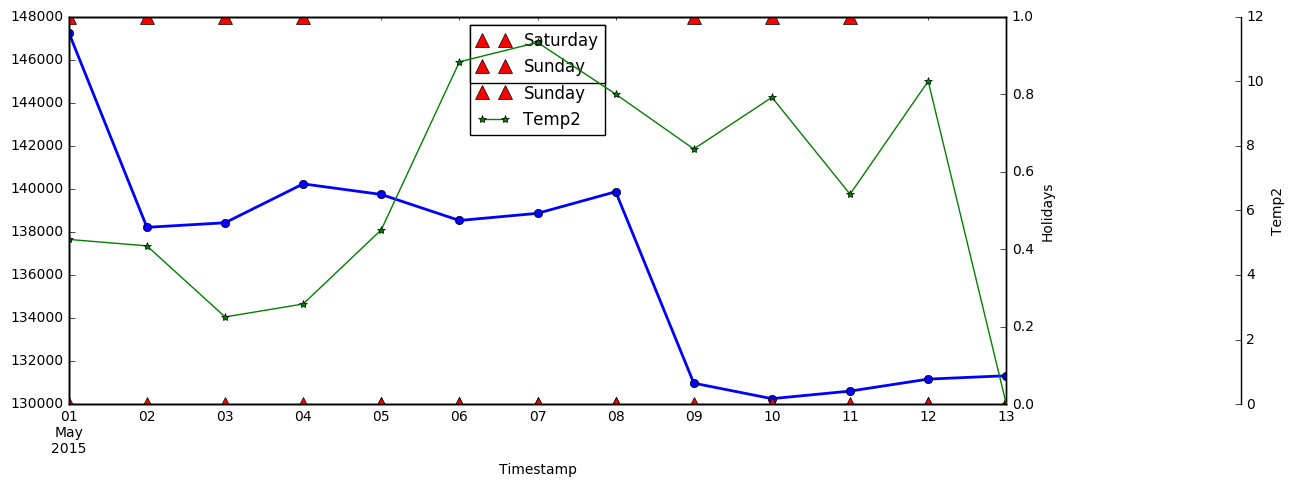

In [167]:
fig, ax = plt.subplots(figsize=(15,5))

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax['FRC'].tail(186).plot(ax = ax,  style='b-', marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

## SARIMA

Specification of SARIMA: ARIMA$(p,d,q)\times (P,D,Q)_s$:
$$ (1-B)^{d} (1-B^s)^{\color{red}{D}} y_t=z_t$$

$$z_t = \underbrace{\mu +\sum_{i=1}^{p} \alpha_i \left(\sum_{k=1}^{\color{red}{P}}\delta_pB^{\color{red}{s}\cdot k}\right) z_{t-i}}\limits_{AR} +\underbrace{\sum_{j=1}^{q} \beta_j\left(\sum_{l=1}^{\color{red}{Q}}\gamma_jB^{\color{red}{s}\cdot l}\right)\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

In [58]:
mod = sm.tsa.statespace.SARIMAX(dta, trend='n', order=(0,1,0), seasonal_order=(0,1,1,7))
results = mod.fit()
print results.summary()

                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1946
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 7)   Log Likelihood              -18629.947
Date:                           Sat, 03 Jun 2017   AIC                          37263.894
Time:                                   06:42:41   BIC                          37275.041
Sample:                               01-01-2010   HQIC                         37267.993
                                    - 04-30-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.7337      0.007   -106.610      0.000      -0.747      -0.720
sigma2       1.29e+07   1.41e+05     91.423

* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - https://onlinecourses.science.psu.edu/stat510/node/62
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model


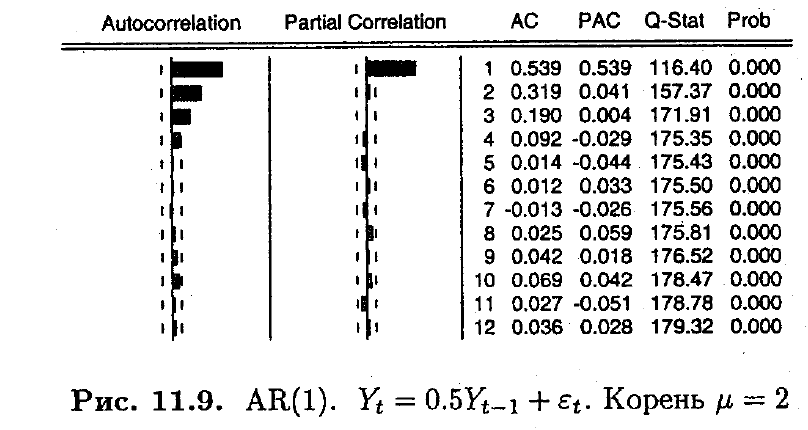

In [104]:
# корреляционная и частная автокорреляиоцнная фнукции для стационарного временного ряда# 
Image('pic/StationaryTS_ACF.png')

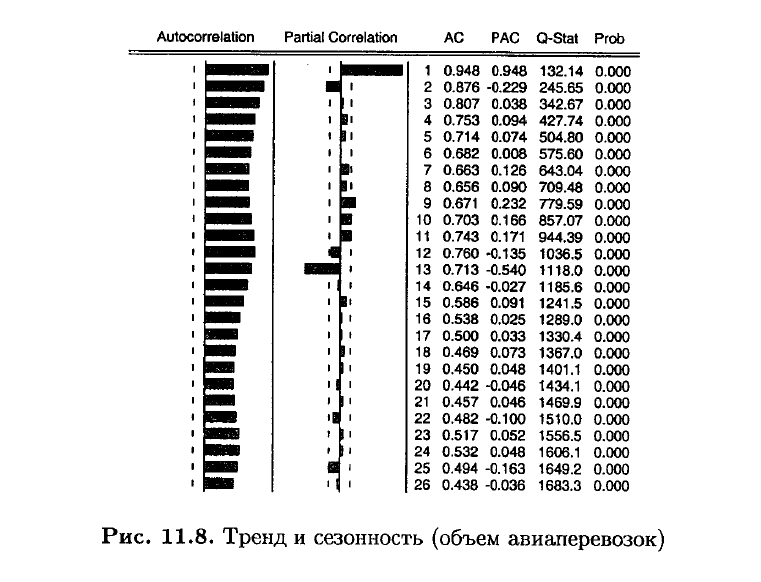

In [105]:
# корреляционная и частная автокорреляиоцнная фнукции для НЕстационарного временного ряда# 
Image('pic/NonStationarTS_ACF.png')

** Модель временного ряда ARIMA**

Если $y_t$ - {НЕ}стационарный, т.е. присутствует ярко выраженный тренд, сезонность, структурные сдвиги

Гипотеза: $d$-разность временного ряда является стационарным временным рядом.

* Лаговый оператор:
    $$L: L y_t = y_{t-1} $$ 
    $$L^i: L^iy_t = L^{i-1}(L y_t) =  y_{t-i}$$;
* Оператор разности:
    $$(1-L)y_t = y_t-y_{t-1}$$
    $$(1-L)^2y_t = (1-L)\bigl((1-L)y_t\bigr) = (1-L)(y_t-y_{t-1})=y_t - 2\cdot t_{t-1}+y_{t-2}$$

See example
https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb

<h1 align="center"> Practice </h1>

<h1 align="center">2. ARIMA Momdel for wage dataset (40%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters your self ** 
Also you can follow the next scheme:
<img src='./ARMA Scheme.png'>


Notes: you need follow to the steps
 * 0) Use data before 01.02.2015 
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is chosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

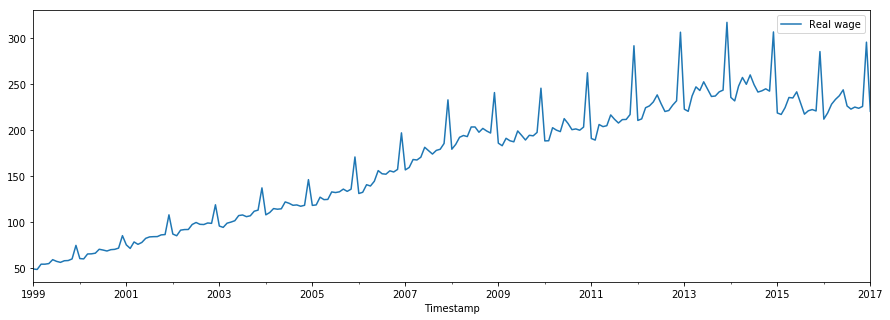

In [93]:
# cut first steps
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(15,5))

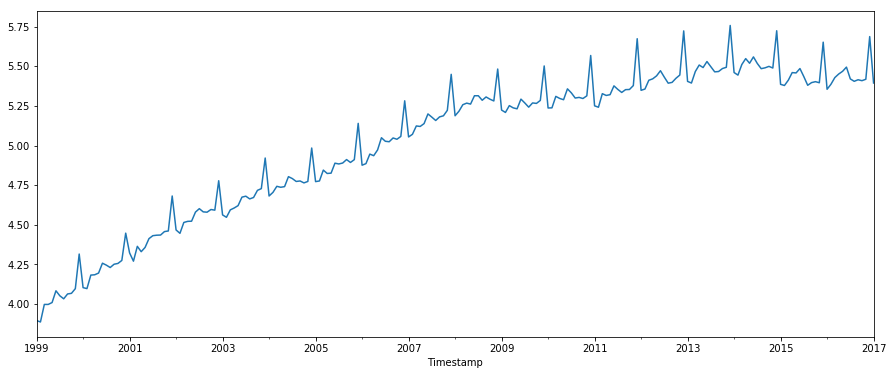

In [145]:
# scaling
from copy import deepcopy
ts_wage_boxcox = deepcopy(ts_wage)
ts_wage_boxcox['wage_boxcox'] = stats.boxcox(ts_wage)[0]
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
ts_wage_boxcox['wage_boxcox'].plot(figsize=(15,6))

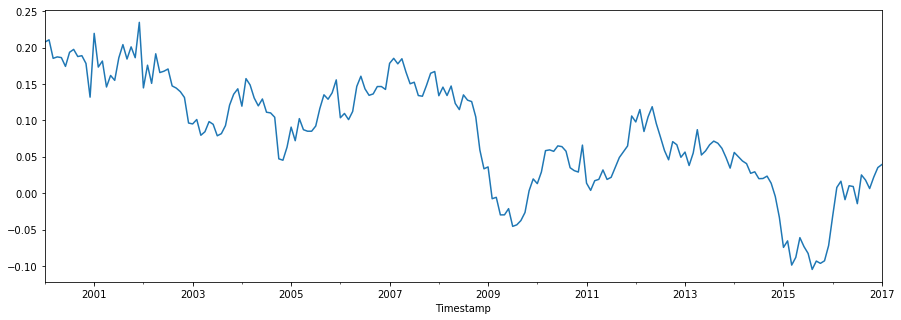

In [146]:
# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts_wage_boxcox.plot(figsize=(15,5))

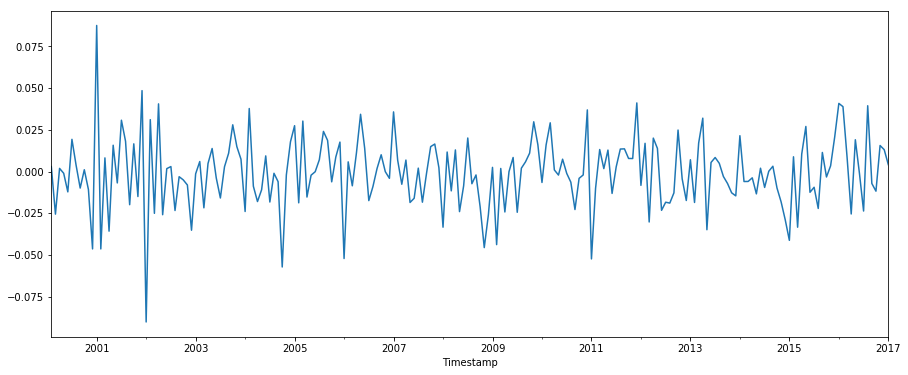

In [147]:
# not stationary yet, diff again 
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot(figsize=(15,6))

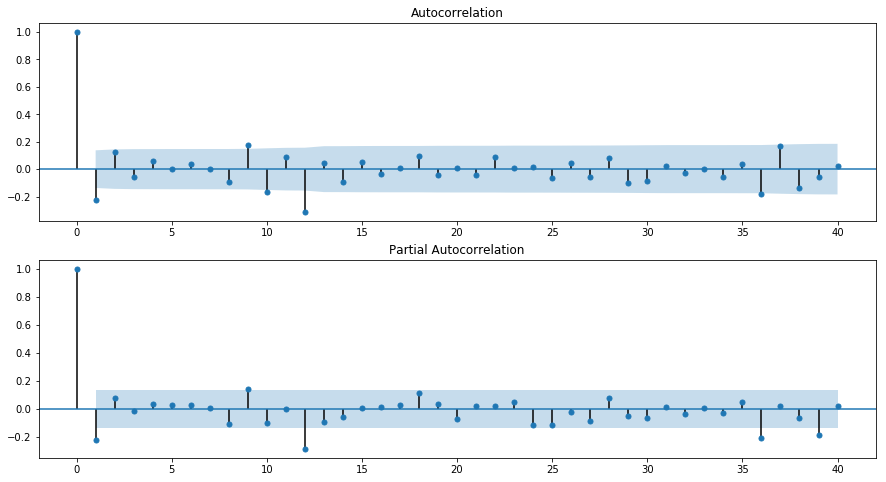

In [157]:
# autocorelation and partial autocorelation
ts = diff_sdiff_ts_wage_boxcox
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.values.squeeze(), lags=40, ax=ax2)

In [296]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(ts))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.062453, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'5%': 0.463, '2.5%': 0.574, '10%': 0.347, '1%': 0.739}


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [297]:
mod = sm.tsa.statespace.SARIMAX(ts_wage, trend='n', order=(1,1,1), seasonal_order=(3,1,3,12))
results = mod.fit()

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [298]:
results.aic

1151.5693148056444

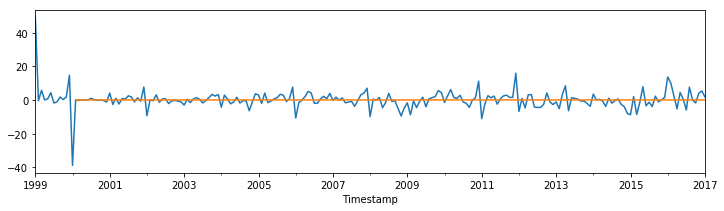

In [299]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax);
ts.plot()

In [300]:
# Darbin_Watson statistic
sm.stats.durbin_watson(results.resid.values)

1.8279671135228914

seems ok

In [301]:
stat = stats.wilcoxon(results.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 11449.000000
pvalue: 0.68


In [302]:
# Normal test
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=133.73781007931154, pvalue=9.103397997708503e-30)

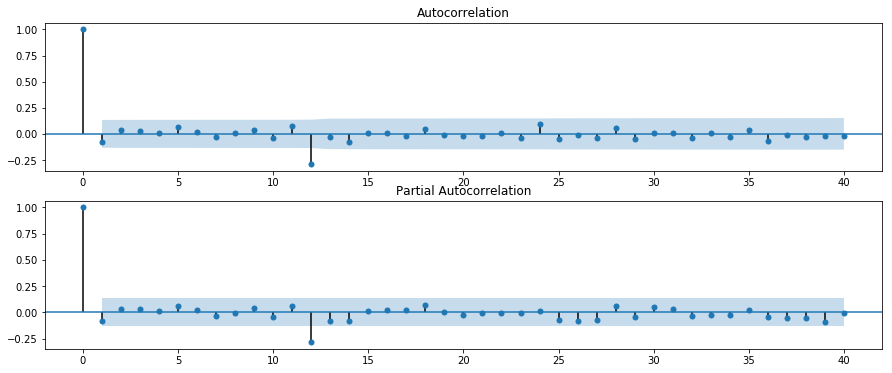

In [303]:
resid = results.resid
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

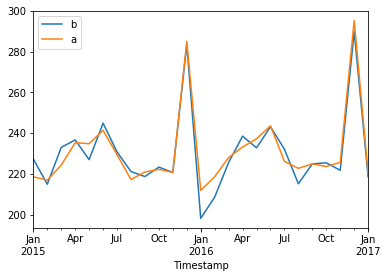

In [304]:
frc_arma = results.predict()
frc_arma = frc_arma.to_frame(name='Real wage')
frc_arma['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='b')
ts_wage['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='a')
plt.legend()

prediction from 2015 to 2017

In [305]:
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [306]:
qualityMAPE(frc_arma.loc['01.01.2015':'01.01.2017'], ts_wage.loc['01.01.2015':'01.01.2017'])[0]

Real wage    0.01873
dtype: float64

In [308]:
 qualityMACAPE(frc_arma.loc['01.01.2015':'01.01.2017'], ts_wage.loc['01.01.2015':'01.01.2017'])[0] 

Real wage    0.018613
dtype: float64

seems to be as in SES

**II. Find the best parameters of ARIMA automaticaly** 
* 0) Use data before 01.02.2015 
* 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
* 2) Run grid search for ARIMA parameters (at least for 3 distinct values for $p,q,d, P, Q, D$). 
How many time does it take?
* 4) Find the best set of parameters according to AIC.
* 5) Build the forecast of the best model and it's forecasting interval for period from 01.02.2015 to 01.01.2017.
* 6) Calculate locc MACAPE of your forecast.

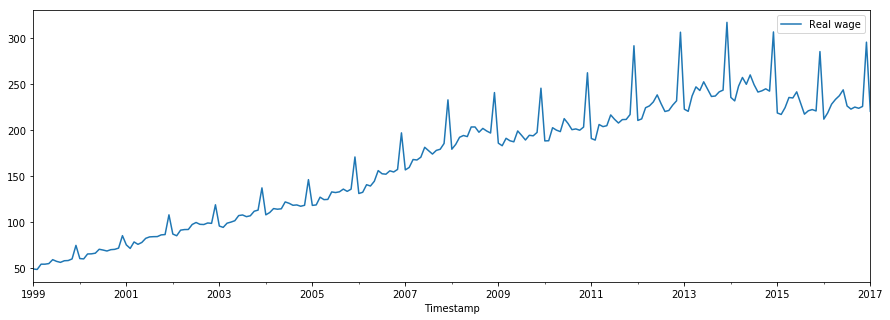

In [309]:
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(15,5))

In [318]:
def my_func(p,d,q,P,D,Q): 
    try:
        mod = sm.tsa.statespace.SARIMAX(ts_wage.loc[:'03.03.2015'], trend='n', order=(p,d,q), seasonal_order=(P,D,Q,12))
        results = mod.fit()
        frc_arma = results.predict(start = '01.01.2015', end = '01.01.2017')
        frc_arma = frc_arma.to_frame(name='Real wage')
        return str(qualityMAPE(frc_arma.loc['01.01.2015':'01.01.2017'], ts_wage.loc['01.01.2015':'01.01.2017'])[0]['Real wage']) +" " + " ".join([str(p),str(d),str(q),str(P),str(D),str(Q)])
    except Exception:
        return "Can't fit model " + " ".join([str(p),str(d),str(q),str(P),str(D),str(Q)])
    
    

In [531]:
from sklearn.grid_search import ParameterGrid
param_grid = {'p': [1,2], 'd' : [1],
             'q': [1,2], 'P' : [1,3,5],
             'D': [1], 'Q' : [1,3,5]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(my_func(params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

0.080988644934 1 1 1 1 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning:

invalid value encountered in sqrt



nan 1 1 2 1 1 1
0.103615296763 2 1 1 1 1 1
Can't fit model 2 1 2 1 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0620439108769 1 1 1 1 1 3
nan 1 1 2 1 1 3


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0862266202137 2 1 1 1 1 3
Can't fit model 2 1 2 1 1 3
Can't fit model 1 1 1 1 1 5
Can't fit model 1 1 2 1 1 5
Can't fit model 2 1 1 1 1 5
Can't fit model 2 1 2 1 1 5


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:928: RuntimeWarning:

Mean of empty slice.

/home/hp/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



0.064027293955 1 1 1 3 1 1
nan 1 1 2 3 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.088252001462 2 1 1 3 1 1
Can't fit model 2 1 2 3 1 1
nan 1 1 1 3 1 3
nan 1 1 2 3 1 3
nan 2 1 1 3 1 3
Can't fit model 2 1 2 3 1 3
Can't fit model 1 1 1 3 1 5
Can't fit model 1 1 2 3 1 5
Can't fit model 2 1 1 3 1 5
Can't fit model 2 1 2 3 1 5
0.0550253502571 1 1 1 5 1 1
nan 1 1 2 5 1 1
0.0670407657351 2 1 1 5 1 1
Can't fit model 2 1 2 5 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0569905233268 1 1 1 5 1 3
nan 1 1 2 5 1 3


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0612038315648 2 1 1 5 1 3
Can't fit model 2 1 2 5 1 3
Can't fit model 1 1 1 5 1 5
Can't fit model 1 1 2 5 1 5
Can't fit model 2 1 1 5 1 5
Can't fit model 2 1 2 5 1 5


best seems to be 0.0550253502571 1 1 1 5 1 1 

<h1 align="center">3. ARIMA Momdel for wage dataset (55%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_consumption.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters yourself **
Follow to the steps from 2.I. 

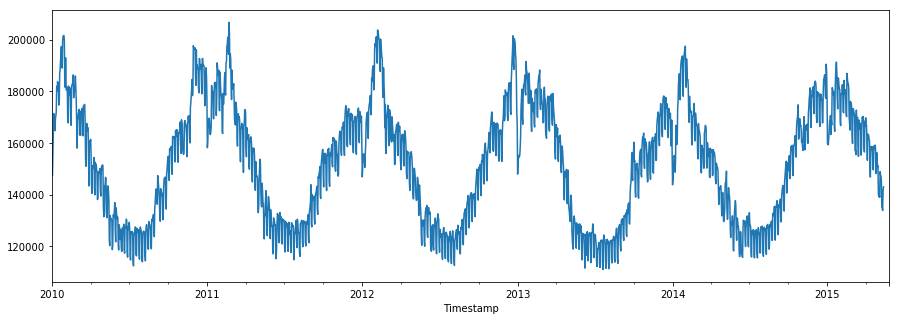

In [322]:
energy_ts = pd.read_csv('./energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts['EnergyConsump'].plot(figsize=(15,5))

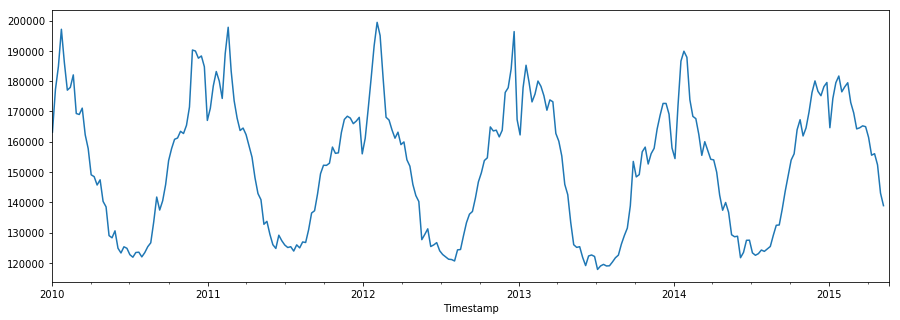

In [332]:
energy_ts['EnergyConsump'].resample("7D").mean().plot(figsize = (15,5))

In [444]:
energy = energy_ts['EnergyConsump']
energy.head()

Timestamp
2010-01-01    147487.171
2010-01-02    155433.800
2010-01-03    164140.232
2010-01-04    171382.848
2010-01-05    170188.290
Name: EnergyConsump, dtype: float64

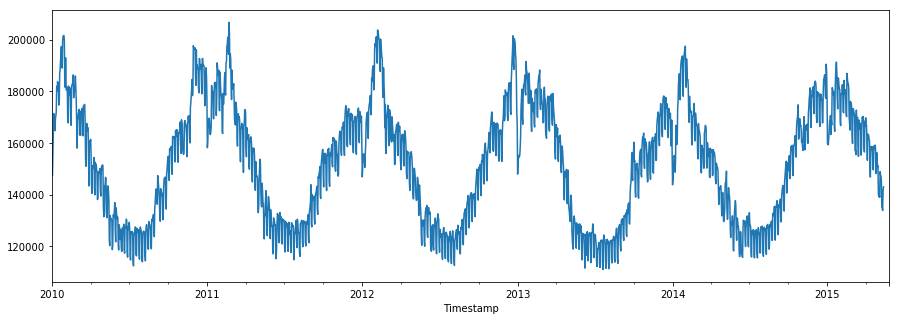

In [445]:
energy.plot(figsize=(15,5))

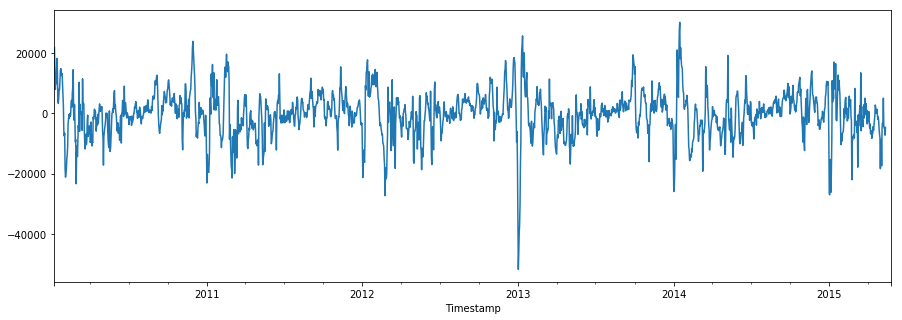

In [446]:
p = 7
energy_shift = (energy - energy.shift(p))[p:]
energy_shift.plot(figsize=(15,5))

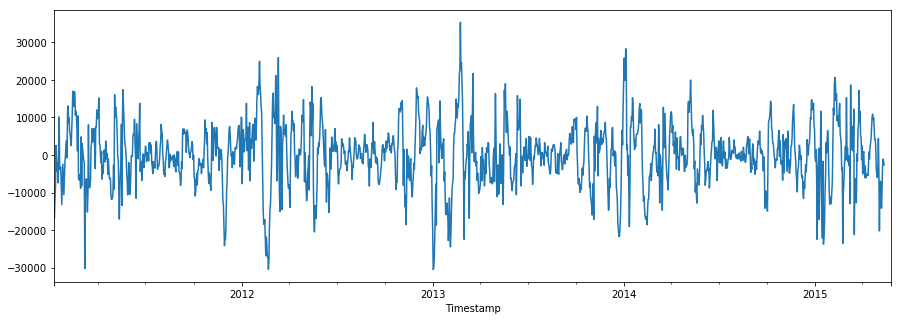

In [447]:
p = 365
energy_shift_1 = (energy_shift - energy_shift.shift(p))[p:]
energy_shift_1.plot(figsize=(15,5))

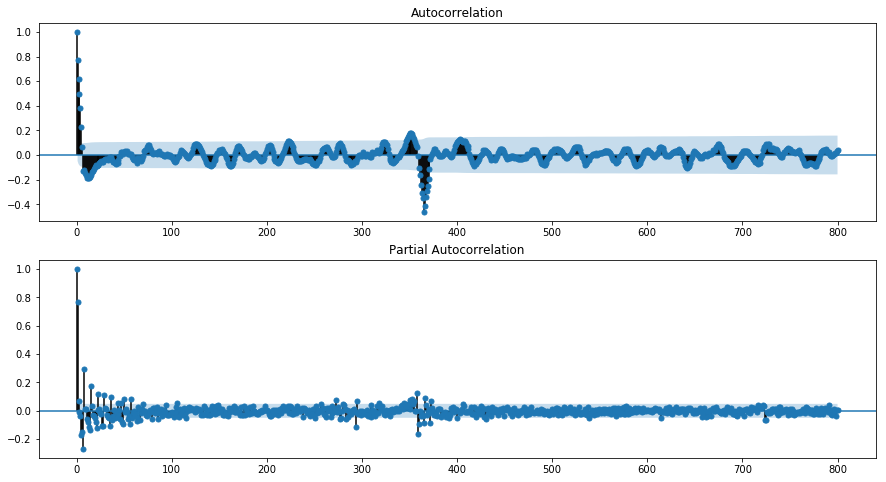

In [449]:
# autocorelation and partial autocorelation
ts = energy_shift_1
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.dropna().values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.dropna().values.squeeze(), lags=800, ax=ax2)

In [450]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(ts.dropna()))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.009940, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'5%': 0.463, '2.5%': 0.574, '10%': 0.347, '1%': 0.739}


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [451]:
mod = sm.tsa.statespace.SARIMAX(energy, trend='c', order=(1,1,1), seasonal_order=(2,2,2,7), enforce_invertibility=False, enforce_stationarity=False)
results = mod.fit()

In [452]:
results.aic

38346.600017105142

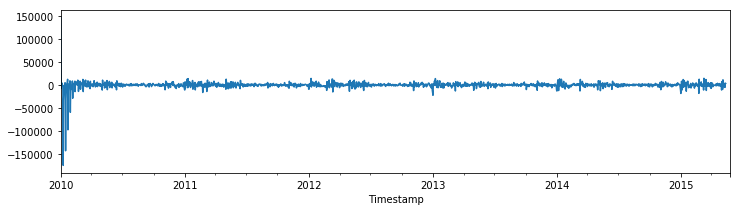

In [453]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax);

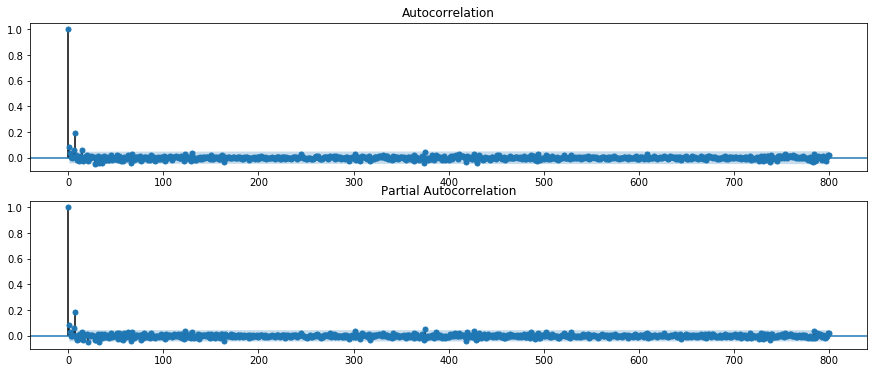

In [454]:
resid = results.resid
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.dropna().values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid.dropna(), lags=800, ax=ax2)

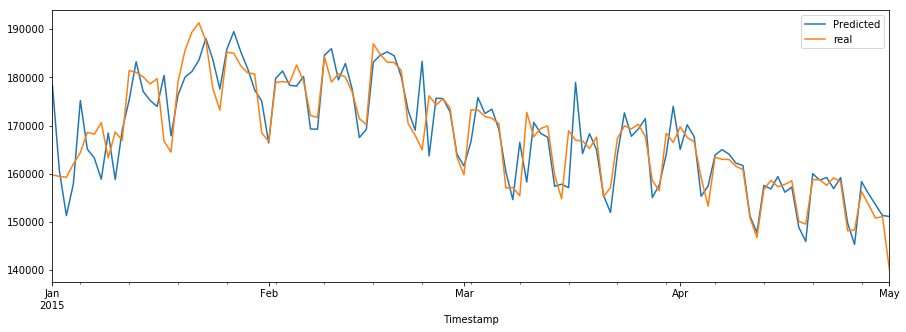

In [461]:
frc_arma = results.predict()
frc_arma.loc['01.01.2015':'05.01.2015'].plot(label='Predicted', figsize = (15,5))
energy.loc['01.01.2015':'05.01.2015'].plot(label='real', figsize = (15,5))
plt.legend()

In [439]:
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [462]:
qualityMAPE(frc_arma.loc['01.01.2015':'05.01.2015'], energy.loc['01.01.2015':'05.01.2015'])[0]

0.021471665214352426

In [463]:
qualityMACAPE(energy.loc['01.01.2015':'05.01.2015'], frc_arma.loc['01.01.2015':'05.01.2015'])[0]

0.021513281005380535

**II. Find the best parameters of ARIMA automaticaly**

I can do it as in previous part, but it will kill my computer, for last part my cpu temps were risen to 90 degree, so , sorry

** III. Adding of exogenious variables**

* 1) Try to add in models from 3.I. and 3.II exogenious variables (at least one of Temp1, Temp2, Saturday and Sunday).
* 2) Does it make accuracy of foreacast for period from 01.02.2015 to 01.01.2017 better?

In [532]:
dta = energy_ts[['EnergyConsump','Temp1', 'Temp2', 'Saturday','Sunday']].dropna()
exogs = dta[['Temp1', 'Temp2', 'Saturday','Sunday']][dta.index<'2015-05-01']
dta = dta[['EnergyConsump']][dta.index<'2015-05-01']

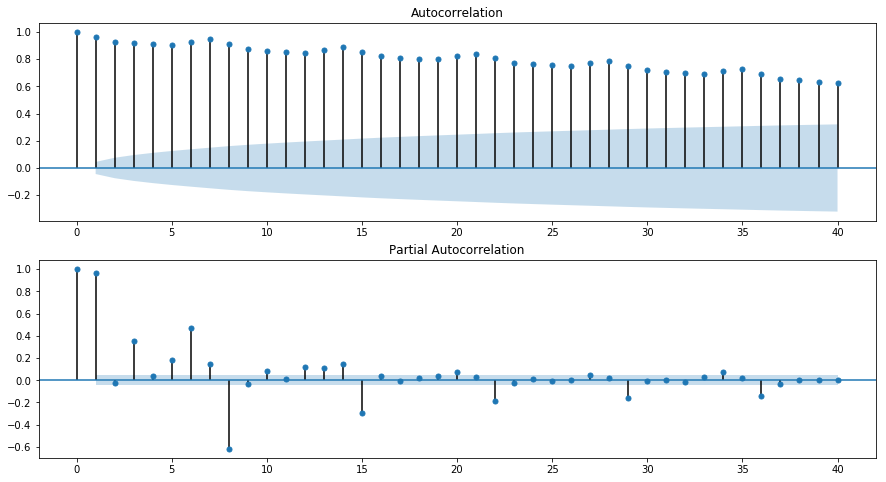

In [533]:
# Use energy data
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

In [540]:
mod = sm.tsa.ARIMA(dta, (7,2,7), exog=exogs)
results = mod.fit()

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [541]:
results.aic

37764.082591098435

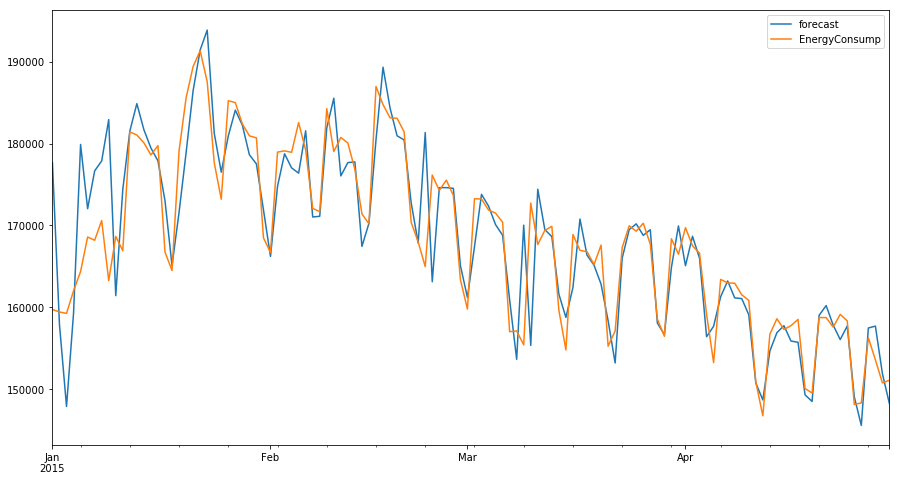

In [542]:
fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
fig = results.plot_predict(start='2015-01-01', end='2015-04-30', ax=ax)

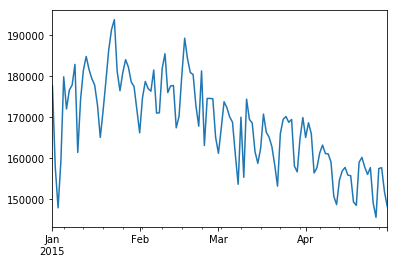

In [543]:
frc_arma = results.predict(start='2015-01-01', end='2015-04-30', typ='levels')
frc_arma.plot()

In [544]:
qualityMAPE(frc_arma.loc['01.01.2015':'05.01.2015'], energy.loc['01.01.2015':'05.01.2015'])[0]

0.01982813547941093

In [545]:
qualityMACAPE(energy.loc['01.01.2015':'05.01.2015'], frc_arma.loc['01.01.2015':'05.01.2015'])[0]

0.019917353463923013

<h1 align="center"> Conclusion </h1>

** you can find HW2 here** 
  * оцените <a href="https://goo.gl/forms/SIa0Elv5PrrEnwwa2"> семинар </a>